In [0]:
%pip install imbalanced-learn


Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
# Import necessary packages
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
display(dbutils.fs.ls("/FileStore/tables/"))


path,name,size,modificationTime
dbfs:/FileStore/tables/ADMISSIONS-1.csv,ADMISSIONS-1.csv,26823,1750137972000
dbfs:/FileStore/tables/ADMISSIONS.csv,ADMISSIONS.csv,26823,1749640575000
dbfs:/FileStore/tables/CALLOUT.csv,CALLOUT.csv,13820,1749640575000
dbfs:/FileStore/tables/CAREGIVERS.csv,CAREGIVERS.csv,178142,1749640576000
dbfs:/FileStore/tables/CHARTEVENTS.csv,CHARTEVENTS.csv,77730362,1749640703000
dbfs:/FileStore/tables/CPTEVENTS.csv,CPTEVENTS.csv,149024,1749640580000
dbfs:/FileStore/tables/DATETIMEEVENTS.csv,DATETIMEEVENTS.csv,1782801,1749640651000
dbfs:/FileStore/tables/DIAGNOSES_ICD-1.csv,DIAGNOSES_ICD-1.csv,48997,1750137987000
dbfs:/FileStore/tables/DIAGNOSES_ICD.csv,DIAGNOSES_ICD.csv,48997,1749640656000
dbfs:/FileStore/tables/DRGCODES.csv,DRGCODES.csv,23122,1749640657000


In [0]:
def load_csv(file_name):
    path = f"dbfs:/FileStore/tables/{file_name}"
    try:
        df = spark.read.option("header", True).csv(path, inferSchema=True)
        print(f"Loaded: {file_name}")
        return df
    except AnalysisException as e:
        print(f" File not found or cannot be read: {file_name}")
        return None

# load data:
admissions_spark  = load_csv("ADMISSIONS.csv")
patients_spark  = load_csv("PATIENTS.csv")
icustays_spark  =  load_csv("ICUSTAYS.csv")

Loaded: ADMISSIONS.csv
Loaded: PATIENTS.csv
Loaded: ICUSTAYS.csv


In [0]:
# Step 2: Convert to Pandas
admissions = admissions_spark.toPandas()
icustays = icustays_spark.toPandas()
patients = patients_spark.toPandas()

In [0]:
# Step 3: Convert datetime columns
admissions['admittime'] = pd.to_datetime(admissions['admittime'])
admissions['dischtime'] = pd.to_datetime(admissions['dischtime'])
admissions['deathtime'] = pd.to_datetime(admissions['deathtime'])

icustays['intime'] = pd.to_datetime(icustays['intime'])
icustays['outtime'] = pd.to_datetime(icustays['outtime'])

patients['dob'] = pd.to_datetime(patients['dob'])
patients['dod'] = pd.to_datetime(patients['dod'])


In [0]:
admissions.columns
icustays.columns
patients.columns


Out[6]: Index(['row_id', 'subject_id', 'gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn',
       'expire_flag'],
      dtype='object')

In [0]:
# Step 4: Merge datasets
df = pd.merge(admissions, icustays, on=['subject_id', 'hadm_id'], how='inner')
df = pd.merge(df, patients, on='subject_id', how='inner')

In [0]:
# Step 5: Create features
df['hospital_expire_flag'] = df['hospital_expire_flag'].fillna(0).astype(int)
# Filter out unrealistic birthdates (DOB before 1900)
df = df[df['dob'].dt.year > 1900]
df['age'] = (df['admittime'] - df['dob']).dt.days // 365
df['icu_los'] = (df['outtime'] - df['intime']).dt.total_seconds() / 3600
df['hospital_los'] = (df['dischtime'] - df['admittime']).dt.total_seconds() / 3600

In [0]:
# Select relevant features
model_df = df[[
    "gender", "age", "ethnicity", "admission_type", "insurance",
    "marital_status", "hospital_expire_flag", "los", "first_careunit", "last_careunit"
]].copy()

# View sample
print(model_df.head())

  gender  age               ethnicity admission_type insurance marital_status  \
0      F   70  BLACK/AFRICAN AMERICAN      EMERGENCY  Medicare      SEPARATED   
1      F   36   UNKNOWN/NOT SPECIFIED      EMERGENCY   Private         SINGLE   
2      F   87   UNKNOWN/NOT SPECIFIED      EMERGENCY  Medicare           None   
3      F   73                   WHITE      EMERGENCY  Medicare       DIVORCED   
4      M   48                   WHITE      EMERGENCY  Medicare       DIVORCED   

   hospital_expire_flag      los first_careunit last_careunit  
0                     0   1.6325           MICU          MICU  
1                     1  13.8507           MICU          MICU  
2                     1   2.6499           MICU          MICU  
3                     0   2.1436            CCU           CCU  
4                     1   1.2938           MICU          MICU  


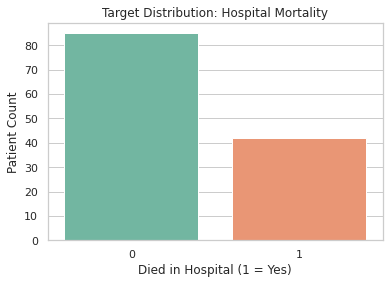

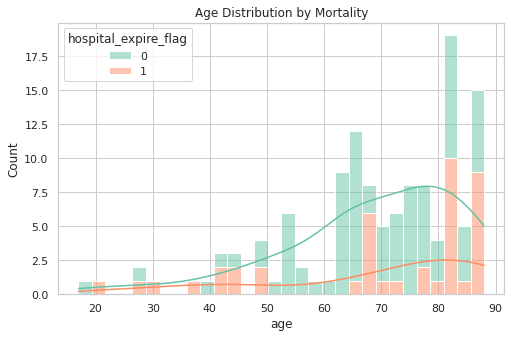

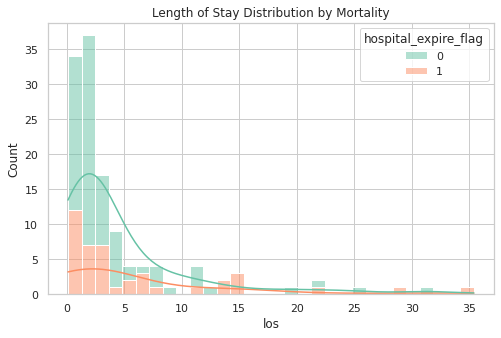

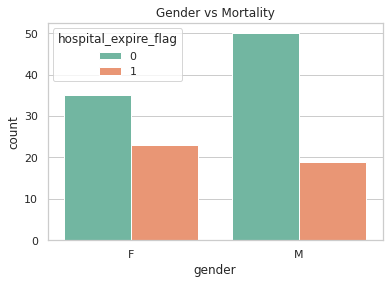

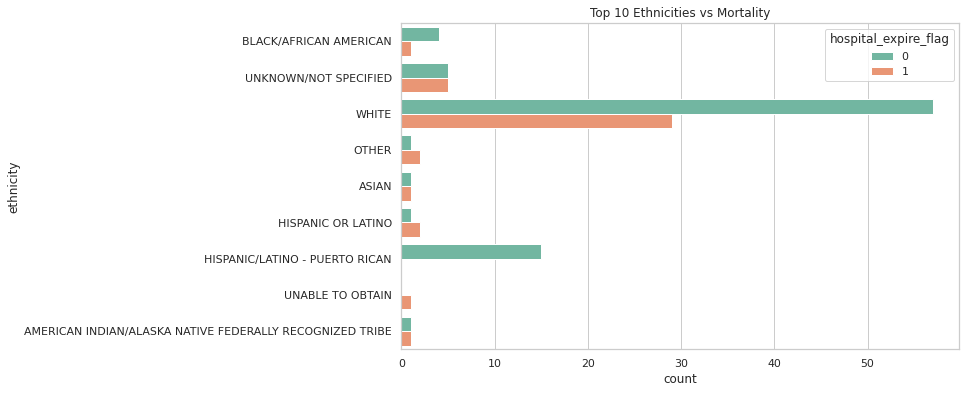

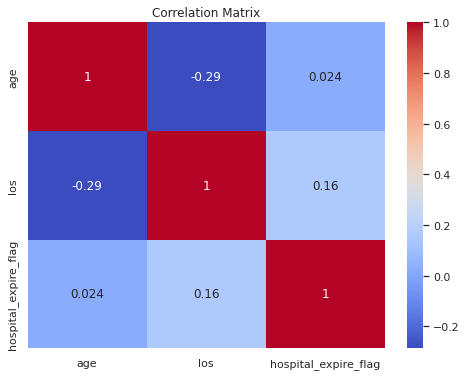

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# 1. Mortality distribution
plt.figure(figsize=(6,4))
sns.countplot(data=model_df, x="hospital_expire_flag", palette="Set2")
plt.title("Target Distribution: Hospital Mortality")
plt.xlabel("Died in Hospital (1 = Yes)")
plt.ylabel("Patient Count")
plt.show()

# 2. Age distribution
plt.figure(figsize=(8,5))
sns.histplot(data=model_df, x="age", hue="hospital_expire_flag", bins=30, kde=True, palette="Set2", multiple="stack")
plt.title("Age Distribution by Mortality")
plt.show()

# 3. LOS distribution
plt.figure(figsize=(8,5))
sns.histplot(data=model_df, x="los", hue="hospital_expire_flag", bins=30, kde=True, palette="Set2", multiple="stack")
plt.title("Length of Stay Distribution by Mortality")
plt.show()

# 4. Gender vs mortality
plt.figure(figsize=(6,4))
sns.countplot(data=model_df, x="gender", hue="hospital_expire_flag", palette="Set2")
plt.title("Gender vs Mortality")
plt.show()

# 5. Ethnicity vs mortality (top 10 ethnicities)
top_ethnicities = model_df["ethnicity"].value_counts().nlargest(10).index
ethnicity_df = model_df[model_df["ethnicity"].isin(top_ethnicities)]

plt.figure(figsize=(10,6))
sns.countplot(data=ethnicity_df, y="ethnicity", hue="hospital_expire_flag", palette="Set2")
plt.title("Top 10 Ethnicities vs Mortality")
plt.show()

# 6. Correlation heatmap (only numeric)
plt.figure(figsize=(8,6))
corr = model_df[["age", "los", "hospital_expire_flag"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


In [0]:
# Step 6: Drop unused columns
df.drop(columns=['admittime', 'dischtime', 'deathtime', 'intime', 'outtime', 'dob', 'dod'], inplace=True)


In [0]:
# Step 7: Fill nulls with median
for col in ['age', 'icu_los', 'hospital_los']:
    df[col] = df[col].fillna(df[col].median())

In [0]:
# Step 8: Normalize
scaler = StandardScaler()
scaled_cols = ['age', 'icu_los', 'hospital_los']
df[scaled_cols] = scaler.fit_transform(df[scaled_cols])

In [0]:
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    print(f"{column}: Capping values below {lower_bound:.2f} and above {upper_bound:.2f}")
    
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

# Apply to age and LOS
model_df = cap_outliers_iqr(model_df, "age")
model_df = cap_outliers_iqr(model_df, "los")


age: Capping values below 36.00 and above 108.00
los: Capping values below -3.77 and above 9.65


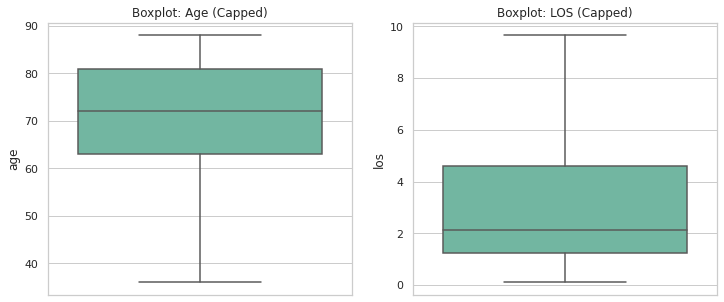

In [0]:
# Boxplot after capping
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(data=model_df, y="age", ax=axes[0], palette="Set2")
axes[0].set_title("Boxplot: Age (Capped)")

sns.boxplot(data=model_df, y="los", ax=axes[1], palette="Set2")
axes[1].set_title("Boxplot: LOS (Capped)")
plt.show()


In [0]:
# Step 9: Outlier treatment using IQR
for col in scaled_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])
    print(f"{col}: Capping values below {lower:.2f} and above {upper:.2f}")

# Apply to age and LOS
model_df = cap_outliers_iqr(model_df, "age")
model_df = cap_outliers_iqr(model_df, "los")

age: Capping values below -2.09 and above 2.47
icu_los: Capping values below -1.32 and above 0.79
hospital_los: Capping values below -1.46 and above 1.13
age: Capping values below 36.00 and above 108.00
los: Capping values below -3.77 and above 9.65


In [0]:
# Step 10: Select features
features = ['age', 'icu_los', 'hospital_los']
X = df[features]
y = df['hospital_expire_flag']


In [0]:
# Step 11: Train-test split (before ADASYN)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, shuffle=True, random_state=42
)

In [0]:
# Step 12: Generate exactly 5000 synthetic samples using ADASYN
adasyn = ADASYN(random_state=42)
X_train_res_all, y_train_res_all = adasyn.fit_resample(X_train, y_train)

# Find how many synthetic samples were created
num_original = len(X_train)
num_extra_needed = 5000

# Check if ADASYN gave enough synthetic samples
synthetic_rows = len(X_train_res_all) - num_original
if synthetic_rows >= num_extra_needed:
    # Slice exactly 5000 synthetic rows
    X_synthetic = X_train_res_all[num_original:num_original + num_extra_needed]
    y_synthetic = y_train_res_all[num_original:num_original + num_extra_needed]
else:
    print(f"ADASYN only generated {synthetic_rows} synthetic rows. Cannot add 5000.")
    X_synthetic = X_train_res_all[num_original:]
    y_synthetic = y_train_res_all[num_original:]

# Concatenate synthetic + original
X_train_res = np.vstack([X_train, X_synthetic])
y_train_res = np.hstack([y_train, y_synthetic])


ADASYN only generated 32 synthetic rows. Cannot add 5000.


In [0]:
# Step 13: Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)

Out[51]: RandomForestClassifier(random_state=42)

In [0]:
# Step 14: Predict on untouched original test set
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

In [0]:
# Step 14: Feature importance (threshold = 0.2)
importances = rf.feature_importances_
important_features = [features[i] for i in range(len(features)) if importances[i] > 0.2]

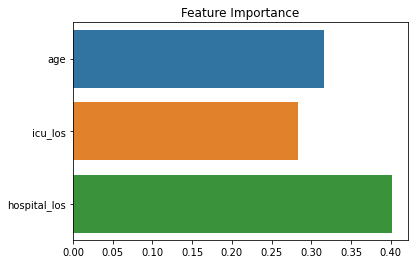

In [0]:
# Plot feature importance
sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.show()

In [0]:
# Step 15: Re-train on selected features
X_train_imp = X_train[important_features]
X_test_imp = X_test[important_features]
rf.fit(X_train_imp, y_train)
y_pred = rf.predict(X_test_imp)

In [0]:
# Step 16: Evaluate
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[19  2]
 [ 5  6]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.90      0.84        21
           1       0.75      0.55      0.63        11

    accuracy                           0.78        32
   macro avg       0.77      0.73      0.74        32
weighted avg       0.78      0.78      0.77        32



ROC-AUC: 0.82
Out[38]: <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f0698caaa00>

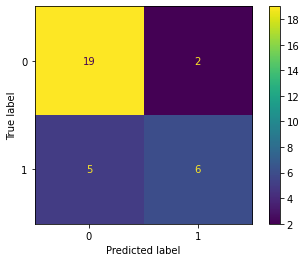

In [0]:
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay

print("ROC-AUC:", roc_auc_score(y_test, y_proba).round(3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


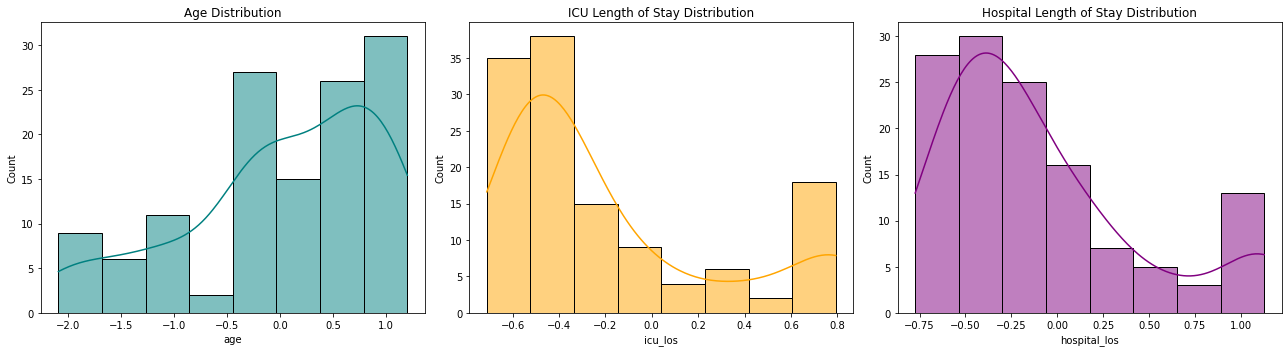

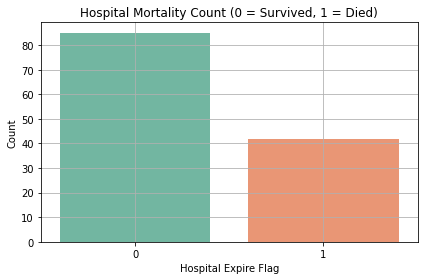

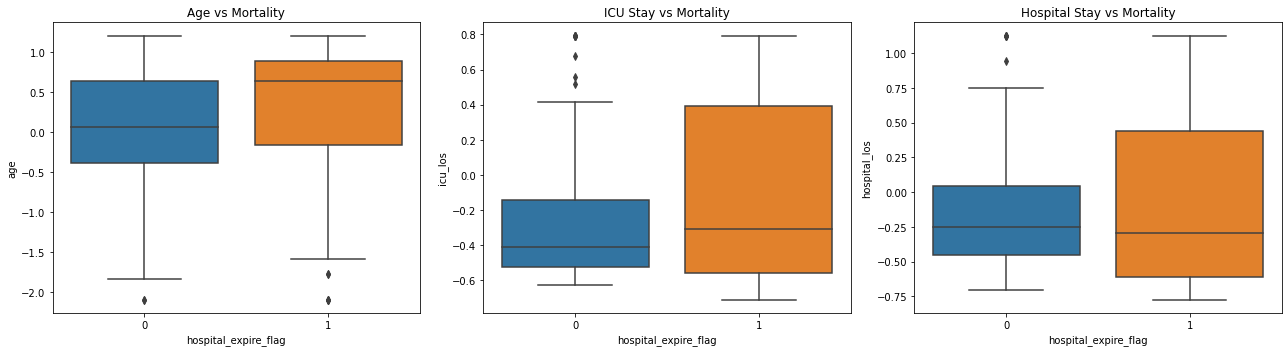

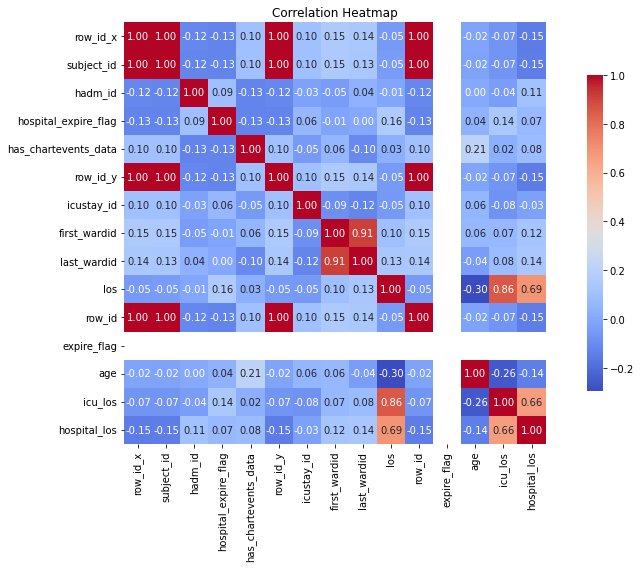

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



# 1. Histograms
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df['age'], kde=True, ax=axs[0], color='teal')
axs[0].set_title("Age Distribution")

sns.histplot(df['icu_los'], kde=True, ax=axs[1], color='orange')
axs[1].set_title("ICU Length of Stay Distribution")

sns.histplot(df['hospital_los'], kde=True, ax=axs[2], color='purple')
axs[2].set_title("Hospital Length of Stay Distribution")

plt.tight_layout()
plt.show()

# 2. Countplot for Mortality
plt.figure(figsize=(6, 4))
sns.countplot(x='hospital_expire_flag', data=df, palette='Set2')
plt.title("Hospital Mortality Count (0 = Survived, 1 = Died)")
plt.xlabel("Hospital Expire Flag")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Boxplots comparing features by mortality
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(x='hospital_expire_flag', y='age', data=df, ax=axs[0])
axs[0].set_title("Age vs Mortality")

sns.boxplot(x='hospital_expire_flag', y='icu_los', data=df, ax=axs[1])
axs[1].set_title("ICU Stay vs Mortality")

sns.boxplot(x='hospital_expire_flag', y='hospital_los', data=df, ax=axs[2])
axs[2].set_title("Hospital Stay vs Mortality")

plt.tight_layout()
plt.show()

# 4. Correlation Heatmap
numeric_df = df.select_dtypes(include=['number'])

# Compute correlation
corr = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .75})
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()